# Gerenciamento de Dependências

In [20]:
# Upgrade do pip
!pip install --upgrade pip

# Instalação dos pacotes
!pip install gdown # Serve pra baixar arquivos do google drive
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install missingno
!pip install matplotlib
!pip install scikit-learn

In [34]:
# Import dos Pacotes
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from scipy.stats import chi2_contingency

# Download do Dataset

In [15]:
!gdown 1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22

Downloading...
From: https://drive.google.com/uc?id=1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22
To: /home/julio/Documentos/faculdade_ia_machine-learning-and-n8n/sods.csv
100%|████████████████████████████████████████| 849k/849k [00:00<00:00, 1.82MB/s]


# Visualização dos Dados

## Funções Auxiliares

In [53]:
def show_distribution_hist(dataset):
    dataset
    for key in dataset.keys():
        print(f"Key: {key}")
        # sns.kdeplot(dataset[key], fill=True)

def show_distribution(dataset):
    ...

## Plots
***
Idade: label com dados númericos, não categóricos. Devo analisar a distribuição, os valores assumidos, o número de valores faltando e, a existência de outliers. Suponho, que algo entre 1 ano à 122 anos, que foi a idade de uma senhorinha que viveu que só, vou usar 125 pra arredondar.

Genêro: label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Suponho, que seja masculino, feminino e outros. Vou precisar fazer o encode, posteriormente.

Etnia:  label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Suponho, que seja parda, branca e negra. Vou precisar fazer o encode, posteriormente.

PCD (Pessoa com Deficiência): label com dados binários, sim ou não. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Vou precisar fazer o encode, posteriormente.

Vive no Brasil: label com dados binários, True ou False. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Vou precisar fazer o encode, posteriormente.

Estado de moradia: label com dados textuais e, categóricos. Devo analisar a distribuição, os valores assumidos e, o número de valores faltando. Devo verificar também se a label assume valores de estados fora do Brasil. Vou precisar fazer o encode, posteriormente.

Nível de ensino:

Formação:

Tempo de experiência:

Linguagens preferidas:

Banco de dados:

Cloud preferida:

Cargo:
***

In [3]:
# Carregar o dataset e ver algumas informações básicas
dataset = pd.read_csv("sods.csv") 
dataset

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,26.0,Masculino,Branca,Não,True,São Paulo (SP),Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, Oracle, MariaDB, HBase, MySQL",Não sei opinar,Analista de Dados/Data Analyst
4267,30.0,Feminino,Branca,Não,True,Minas Gerais (MG),Mestrado,Outras Engenharias,de 1 a 2 anos,Python,"SQL SERVER, SAP HANA",Azure (Microsoft),Engenheiro de Dados/Arquiteto de Dados/Data En...
4268,29.0,Masculino,Branca,Não,True,São Paulo (SP),Mestrado,Outras Engenharias,de 4 a 6 anos,NaN,NaN,NaN,NaN
4269,NaN,Masculino,Branca,Não,True,São Paulo (SP),Não tenho graduação formal,NaN,Menos de 1 ano,Python,"Microsoft Access, Oracle",Azure (Microsoft),Outra Opção


In [29]:
dataset.dtypes

idade                      float64
genero                      object
etnia                       object
pcd                         object
vive_no_brasil                bool
estado_moradia              object
nivel_ensino                object
formacao                    object
tempo_experiencia_dados     object
linguagens_preferidas       object
bancos_de_dados             object
cloud_preferida             object
cargo                       object
dtype: object

Exibindo o número de valores faltando por coluna. Necessário para a análise de quais colunas utilizar.

Número de valores faltando.
idade: 74 -> 1.73%
genero: 9 -> 0.21%
etnia: 0 -> 0.00%
pcd: 0 -> 0.00%
vive_no_brasil: 0 -> 0.00%
estado_moradia: 115 -> 2.69%
nivel_ensino: 0 -> 0.00%
formacao: 122 -> 2.86%
tempo_experiencia_dados: 577 -> 13.51%
linguagens_preferidas: 1292 -> 30.25%
bancos_de_dados: 1293 -> 30.27%
cloud_preferida: 1290 -> 30.20%
cargo: 1290 -> 30.20%


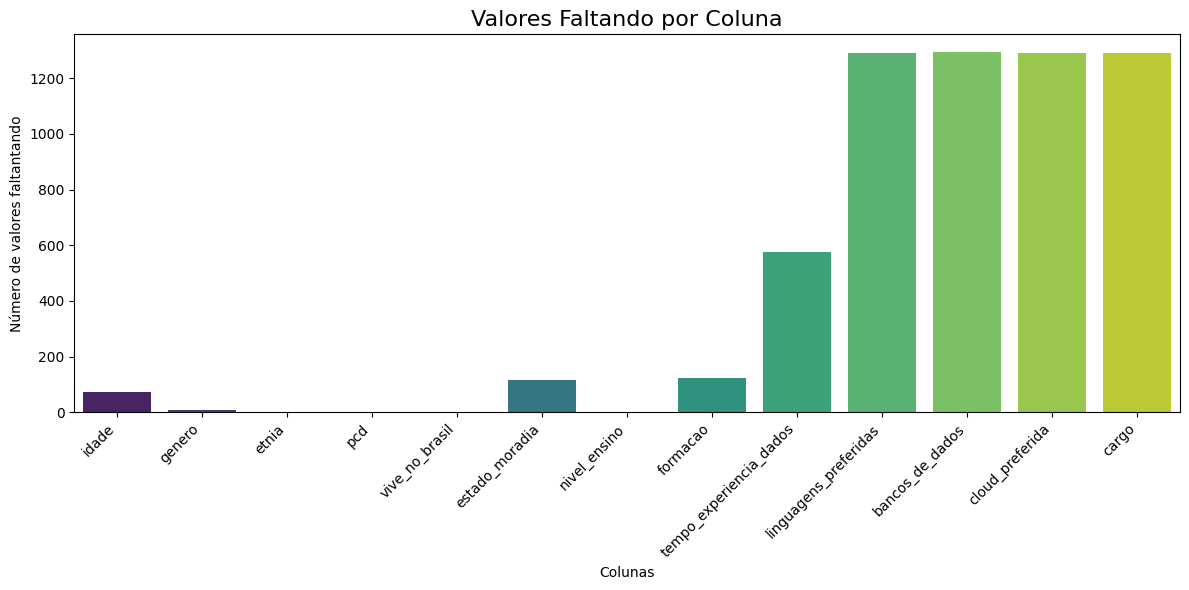

In [37]:
# Verificar o  número de valores ausentes nas tabelas.

missing_counts = dataset.isnull().sum().reset_index()
missing_counts.columns = ["coluna", "valores_faltantes"]

print("Número de valores faltando.")
for col, val in dataset.isnull().sum().items():
    print(f"{col}: {val} -> {val/4271*100:.2f}%")

plt.figure(figsize=(12,6))
sns.barplot(data=missing_counts, 
            x="coluna", 
            y="valores_faltantes",
            hue="coluna",
            palette="viridis",
            legend=False,
            dodge=False)

plt.xticks(rotation=45, ha='right')
plt.title("Valores Faltando por Coluna", fontsize=16)
plt.xlabel("Colunas")
plt.ylabel("Número de valores faltantando")
plt.tight_layout()
plt.show()

# Pode ser uma boa printar também o número geral de linhas que possui pelo menos um valor faltando.

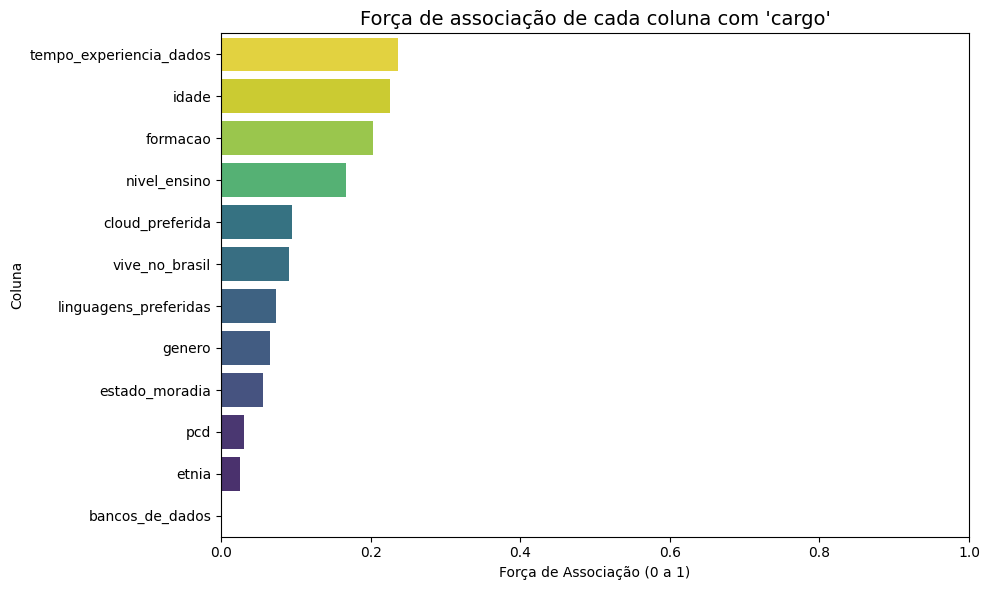

In [35]:
# ----- Funções auxiliares -----
def cramers_v_corrected(x, y):
    """Associação categórico↔categórico"""
    conf = pd.crosstab(x, y)
    if conf.size == 0:
        return np.nan
    chi2 = chi2_contingency(conf)[0]
    n = conf.to_numpy().sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = conf.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1)) if n > 1 else 0
    rcorr = r - ((r - 1)**2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1)**2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def correlation_ratio(categories, measurements):
    """Associação numérico↔categórico"""
    mask = (~pd.isna(categories)) & (~pd.isna(measurements))
    if mask.sum() == 0:
        return np.nan
    categories = pd.Series(categories[mask], dtype="category")
    measurements = measurements[mask]
    overall_mean = measurements.mean()
    means = measurements.groupby(categories, observed=False).mean()
    counts = measurements.groupby(categories, observed=False).count()
    ss_between = (counts * (means - overall_mean)**2).sum()
    ss_total = ((measurements - overall_mean)**2).sum()
    return float(np.sqrt(ss_between / ss_total)) if ss_total != 0 else 0.0

# ----- Cálculo das associações com 'formacao' -----
target = "cargo"
associacoes = []

for col in dataset.columns:
    if col == target:
        continue
    if pd.api.types.is_numeric_dtype(dataset[col]):
        # numérico × categórico
        assoc = correlation_ratio(dataset[target], dataset[col])
    else:
        # categórico × categórico
        assoc = cramers_v_corrected(dataset[target], dataset[col])
    associacoes.append({"coluna": col, "associacao": assoc})

assoc_df = pd.DataFrame(associacoes).sort_values(by="associacao", ascending=False)

# ----- Plot -----
plt.figure(figsize=(10,6))
sns.barplot(data=assoc_df,
            x="associacao", 
            y="coluna", 
            hue="associacao",
            palette="viridis",
            legend=False,
            dodge=False)
plt.title(f"Força de associação de cada coluna com '{target}'", fontsize=14)
plt.xlabel("Força de Associação (0 a 1)")
plt.ylabel("Coluna")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


# Tratamento dos Dados

In [ ]:
# Downdload do dataset